# Principal Components Analysis

Let's explore how PCA works, both at a low-level and with `scikit-learn`.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

We'll use a standard dataset that quantifies irises (flowers)

In [2]:
iris = load_iris()

It happens that this dataset is already in the form of a `pandas` dataframe, so we'll cast it as such and pull out the quantities we need:

In [3]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

df['class'] = iris.target
print(df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     class  
0        0  
1

Now just read in the pieces we want:

In [5]:
x = df.drop(labels='class', axis=1).values
y = df['class'].values

Now we'll implement a class to calculate the Principal Components for us.

In [6]:
class convers_pca():
    def __init__(self, no_of_components):
        self.no_of_components = no_of_components
        self.eigen_values = None
        self.eigen_vectors = None
    
    # transform data into PCA basis
    def transform(self, x):
        return np.dot(x - self.mean, self.projection_matrix.T)
    
    # go from PCA basis to normal basis
    def inverse_transform(self, x):
        return np.dot(x, self.projection_matrix) + self.mean
    
    def fit(self, x):
        self.no_of_components = x.shape[1] if self.no_of_components is None else self.no_of_components
        self.mean = np.mean(x, axis=0)
        
        # rawvar=False means the columns should correspond to the variables 
        cov_matrix = np.cov(x - self.mean, rowvar=False)
        
        # find the eigenvectors and eigenvalues
        self.eigen_values, self.eigen_vectors = np.linalg.eig(cov_matrix)
        
        # make them column vectors instead of row vectors
        self.eigen_vectors = self.eigen_vectors.T
        
        # sort by the eigenvalues
        self.sorted_components = np.argsort(self.eigen_values)[::-1]
        
        # just keep up to the first N eigenvalues
        self.projection_matrix = self.eigen_vectors[self.sorted_components[:self.no_of_components]]

        # find the variance captured by the principal components, compare to total variance
        self.explained_variance = self.eigen_values[self.sorted_components]
        self.explained_variance_ratio = self.explained_variance / self.eigen_values.sum()

Before we do anything, we should transform the data to have mean=0 and variance=1:

In [7]:
std = StandardScaler()
transformed = StandardScaler().fit_transform(x)

Now call the PCA class that we wrote above.  We'll ask to keep the first two principal components of the dataset.

In [8]:
pca = convers_pca(no_of_components=2)
pca.fit(transformed)

Since we only kept two principal components, we can draw them on a 2D plot, color-coding each category of iris type:

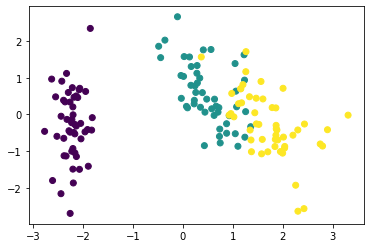

In [9]:
x_std = pca.transform(transformed)

plt.figure()
plt.scatter(x_std[:, 0], x_std[:, 1], c=y)

We can also use the `scikit-learn` implementation of PCA.  In this case we're going to load image data, so the dimensionality of the input dataset is much larger, but we'll still keep just the first two principal components.

## Using `scikit-learn` for PCA

In [10]:
from sklearn.decomposition import PCA


from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

(1797, 64)


We see that the data are composed of 1797 rows and 64 features.  So when we project down to a lower dimensional space, it should be to fewer than 64 features!

(1797, 2)


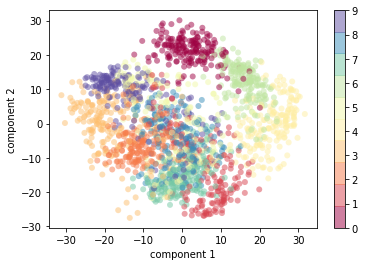

In [11]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)

print(projected.shape)

plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

The `scikit-learn` implementation gives us some useful information, such as the "explained variance" as a function of the number of components we project into.  This allows us to understand how many components we need to capture X% of the information in the data sample:

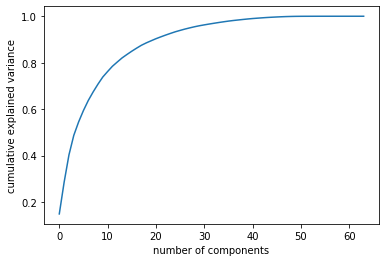

In [12]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Using PCA for de-noising

Let's take a closer look at the image data we downloaded above:

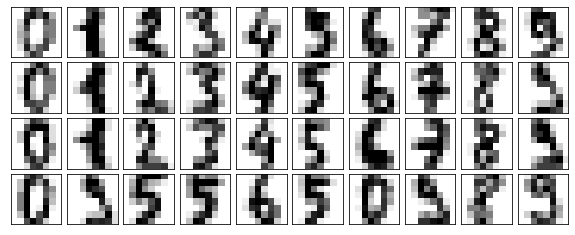

In [13]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now let's add some noise to these images:

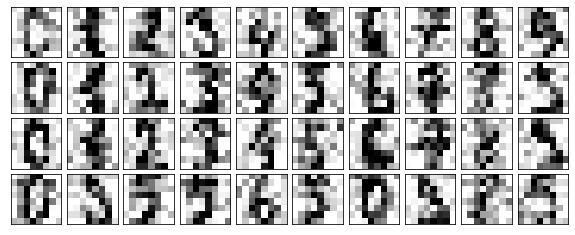

In [14]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

We can ask for a PCA algorithm that keeps 50% of the information.  This means projecting into fewer dimensions than a version that keeps >50%.

In [15]:
pca = PCA(0.90).fit(noisy)
pca.n_components_

49

Now we can plot the digits after passing them through PCA (and back):

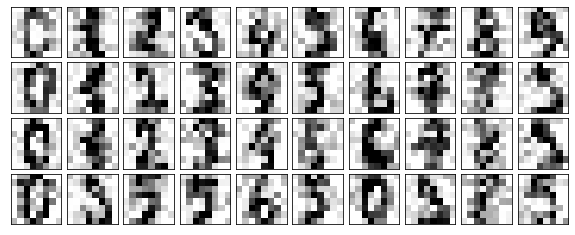

In [16]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

**Exercise**: play around with different thresholds for the PCA algorithm -- at what point do the images become unrecognizable?  At what point does the noise reep back in?

### More images!

This doesn't just work with numbers, we can do something similar with faces!

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [18]:
pca = PCA(150)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Let's take a look at what the principal components actually look like for these images:

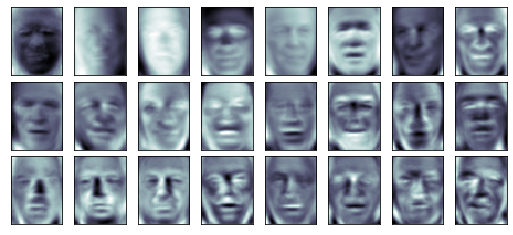

In [19]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

Check how many components we need to capture X% of the information in an image:

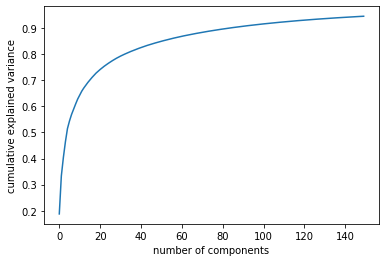

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Now pass the faces through the PCA transform:

In [21]:
# Compute the components and projected faces
pca = PCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

And let's take a look at the results:

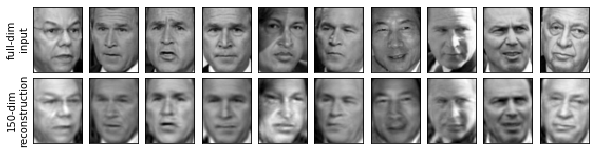

In [22]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

**Exercise**: Play around with the number of components we keep, how does it change the results?

References:
* [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)
